# Notebook loading metricasports data and reducing the number of points

In [1]:
import pandas as pd
import numpy as np
from mplsoccer.pitch import Pitch
from matplotlib.colors import LinearSegmentedColormap
# Ramer-Douglas-Peucker algorithm for reducing points
from rdp import rdp

Load the data

In [2]:
# load away data
link1 = ('https://raw.githubusercontent.com/metrica-sports/sample-data/master/'
         'data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv')
df_away = pd.read_csv(link1, skiprows=2)
df_away.sort_values('Time [s]', inplace=True)

# load home data
link2 = ('https://raw.githubusercontent.com/metrica-sports/sample-data/master/'
         'data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv')
df_home = pd.read_csv(link2, skiprows=2)
df_home.sort_values('Time [s]', inplace=True)

Reset the column names: column names aren't great so this sets the player ones with _x and _y suffixes

In [3]:
def set_col_names(df):
    cols = list(np.repeat(df.columns[3::2], 2))
    cols = [col+'_x' if i % 2 == 0 else col+'_y' for i, col in enumerate(cols)]
    cols = np.concatenate([df.columns[:3], cols])
    df.columns = cols

set_col_names(df_away)
set_col_names(df_home)

Split off a df_ball dataframe and drop the ball columns from the player dataframes

In [4]:
df_ball = df_away[['Period', 'Frame', 'Time [s]', 'Ball_x', 'Ball_y']].copy()
df_home.drop(['Ball_x', 'Ball_y'], axis=1, inplace=True)
df_away.drop(['Ball_x', 'Ball_y'], axis=1, inplace=True)
df_ball.columns = ['period', 'frame', 'time_sec', 'x', 'y']

Convert to long form from wide form

In [5]:
def to_long_form(df):
    df = pd.melt(df, id_vars=df.columns[:3], value_vars=df.columns[3:], var_name='player')
    df.loc[df.player.str.contains('_x'), 'coordinate'] = 'x'
    df.loc[df.player.str.contains('_y'), 'coordinate'] = 'y'
    df = df.dropna(axis=0, how='any')
    df['player'] = df.player.str[6:-2]
    df = (df.set_index(['Period', 'Frame', 'Time [s]', 'player', 'coordinate'])['value']
          .unstack()
          .reset_index()
          .rename_axis(None, axis=1))
    df.columns = ['period', 'frame', 'time_sec', 'player', 'x', 'y']
    return df


df_away = to_long_form(df_away)
df_home = to_long_form(df_home)

Scale to the pitch dimensions (x = 105, y = 68)

In [6]:
def scale_dims(df, width=68, length=105):
    df['x'] = df['x'] * length
    df['y'] = df['y'] * width
    return df

df_home = scale_dims(df_home)
df_home = scale_dims(df_away)
df_home = scale_dims(df_ball)

Sort the ball to make sure its in the right order

In [7]:
df_ball.sort_values(['period', 'frame'], inplace=True)

Plot of all the ball points

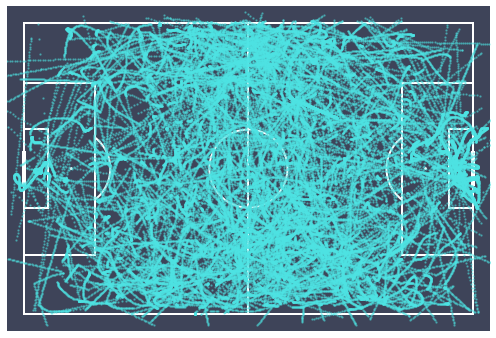

In [8]:
pitch = Pitch(pitch_color='#3e4459', line_color='white', figsize=(7, 8), pitch_type='uefa')
fig, ax = pitch.draw()
sc = pitch.scatter(df_ball.x, df_ball.y, color='#4fe4e4', alpha=0.4, s=2, ax=ax)
fig.savefig('example1.png', facecolor='#3e4459')

Get a mask of coordinates to keep using the Ramer-Douglas-Peucker algorithm for reducing the number of points in a curve
https://stackoverflow.com/questions/14631776/calculate-turning-points-pivot-points-in-trajectory-path

In [9]:
df_ball_not_null = df_ball[df_ball.x.notnull()].copy()
mask = rdp(df_ball_not_null[['x', 'y']].values, algo="iter", return_mask=True, epsilon=0.1)

Reduce the ball data using the mask

In [10]:
keep_ball_idx = df_ball_not_null[mask].index
df_ball_reduced = df_ball[df_ball.index.isin(keep_ball_idx)].copy()
print('Percentage of points kept:', round(len(df_ball_reduced) / len(df_ball)* 100, 2),'%')

Percentage of points kept: 2.8 %


Plot a line of the points between 500s and 1000s (blue) and show the reduced points (yellow)

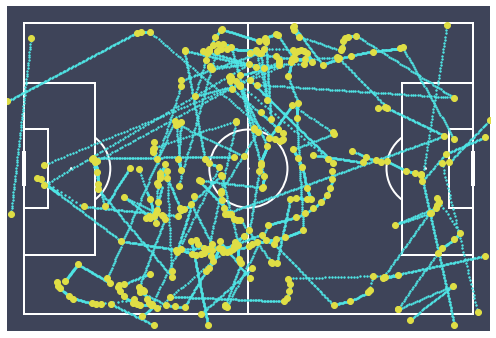

In [11]:
pitch = Pitch(pitch_color='#3e4459', line_color='white', figsize=(7, 8), pitch_type='uefa')
fig, ax = pitch.draw()
start = 500
end = 1000
cmap = LinearSegmentedColormap.from_list('fluo', ['#c3e08c', '#57e5d6'])
mask_ball = (df_ball.period == 1) & (df_ball.time_sec >= start) & (df_ball.time_sec <= end)
sc1 = pitch.scatter(df_ball[mask_ball].x, df_ball[mask_ball].y,
                    c='#4fe4e4',
                    #c=np.arange(mask_ball.sum()), cmap=cmap,
                    s=2, ax=ax)
mask_reduced_ball = (df_ball_reduced.period == 1) & (df_ball_reduced.time_sec >= start) & (df_ball_reduced.time_sec <= end)
sc1 = pitch.scatter(df_ball_reduced[mask_reduced_ball].x, df_ball_reduced[mask_reduced_ball].y, color='#dfde45', ax=ax)
fig.savefig('example2.png', facecolor='#3e4459')